In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install filterpy

     |████████████████████████████████| 184kB 14.0MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110450 sha256=cacca62a7cff3749e0aa22adb7ce4943e19189b28ad7d53511596875f1294a70
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


## Imports

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment
import os, sys, time, datetime, random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from numba import jit
import numpy as np
from collections import defaultdict
from filterpy.kalman import KalmanFilter

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
BASE_PATH = '/content/drive/My Drive/CVTermProject/train/'
CLASS_PATH = BASE_PATH + 'config/coco.names'
DATA_CONFIG_PATH = BASE_PATH + 'config/coco.data'
MODEL_CONFIG_PATH = BASE_PATH + 'config/yolov3.cfg'
WEIGHTS_PATH = BASE_PATH + 'checkpoints/new/499.weights'

In [ ]:
def read_classes(path):
  with open(path, "r") as file:
    return file.read().strip().split("\n")

In [ ]:
img_size=416
conf_thres=0.8
nms_thres=0.2

In [ ]:
def read_data(path):
  with open(path, "r") as file:
    data = file.readlines()

  config = dict()
  for d in data:
    d = d.strip()
    if len(d) < 1:
      continue
    key, value = d.split("=")
    key = key.strip()
    value = value.strip()
    config[key] = value
  
  return config

In [ ]:
def parse_model_config(path):
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs

### Define YOLO model config

In [ ]:
class EmptyLayer(nn.Module):

  def __init__(self):
    super(EmptyLayer, self).__init__()

In [ ]:
class YOLO(nn.Module):
  def __init__(self, anchors, num_classes, dimensions):
    super(YOLO, self).__init__()
    self.anchors = anchors
    self.num_anchors = len(anchors)
    self.num_classes = num_classes
    self.bbox = 5 + num_classes
    self.dimensions = dimensions
    self.ignore_thres = 0.5
    self.lambda_coord = 1

    self.mse_loss = nn.MSELoss()
    self.bce_loss = nn.BCELoss()
    self.ce_loss = nn.CrossEntropyLoss()
  

  def forward(self, x, targets=None):
    nB = x.size(0)
    grid_size = x.size(2)

    stride = self.dimensions / grid_size

    FloatTensor = torch.cuda.FloatTensor if x.is_cuda else torch.FloatTensor
    LongTensor = torch.cuda.LongTensor if x.is_cuda else torch.LongTensor
    ByteTensor = torch.cuda.ByteTensor if x.is_cuda else torch.ByteTensor

    prediction = x.view(nB, self.num_anchors, self.bbox, grid_size, grid_size).permute(0, 1, 3, 4, 2).contiguous()

    # Get outputs
    x = torch.sigmoid(prediction[..., 0])  # Center x
    y = torch.sigmoid(prediction[..., 1])  # Center y
    w = prediction[..., 2]  # Width
    h = prediction[..., 3]  # Height
    confidence = torch.sigmoid(prediction[..., 4])  # Conf
    clas = torch.sigmoid(prediction[..., 5:])  # Cls pred.
    scaled_anchors = FloatTensor([(i / stride, j / stride) for i, j in self.anchors])

    predicted_boxes = FloatTensor(prediction[..., :4].shape)
    predicted_boxes[..., 0] = x.data + torch.arange(grid_size).repeat(grid_size, 1).view([1, 1, grid_size, grid_size]).type(FloatTensor)
    predicted_boxes[..., 1] = y.data + torch.arange(grid_size).repeat(grid_size, 1).t().view([1, 1, grid_size, grid_size]).type(FloatTensor)
    predicted_boxes[..., 2] = torch.exp(w.data) * scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
    predicted_boxes[..., 3] = torch.exp(h.data) * scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))

    if targets is not None:
      if x.is_cuda:
        self.mse_loss = self.mse_loss.cuda()
        self.bce_loss = self.bce_loss.cuda()
        self.ce_loss = self.ce_loss.cuda()

      nGT, nCorrect, mask, conf_mask, tx, ty, tw, th, tconf, tcls = build_targets(
          pred_boxes = predicted_boxes.cpu().data,
          pred_conf = confidence.cpu().data,
          pred_cls = clas.cpu().data,
          target=targets.cpu().data,
          anchors=scaled_anchors.cpu().data,
          num_anchors = self.num_anchors,
          num_classes = self.num_classes,
          grid_size=grid_size,
          ignore_thres=self.ignore_thres,
          img_dim = self.dimensions
      )

      proposals = int((confidence > 0.5).sum().item())
      recall = float(nCorrect / nGT) if nGT else 1

      precision = 0

      if proposals > 0:
        precision = float(nCorrect / proposals)

      mask = Variable(mask.type(ByteTensor))
      conf_mask = Variable(conf_mask.type(ByteTensor))

      tx = Variable(tx.type(FloatTensor), requires_grad=False)
      ty = Variable(ty.type(FloatTensor), requires_grad=False)
      tw = Variable(tw.type(FloatTensor), requires_grad=False)
      th = Variable(th.type(FloatTensor), requires_grad=False)
      tconf = Variable(tconf.type(FloatTensor), requires_grad=False)
      tcls = Variable(tcls.type(FloatTensor), requires_grad=False)

      conf_mask_true = mask
      conf_mask_false = conf_mask - mask

      loss_x = self.mse_loss(x[mask], tx[mask])
      loss_y = self.mse_loss(y[mask], ty[mask])
      loss_w = self.mse_loss(w[mask], tw[mask])
      loss_h = self.mse_loss(h[mask], th[mask])


      loss_conf = self.bce_loss(confidence[conf_mask_false], tconf[conf_mask_false]) + self.bce_loss(
                confidence[conf_mask_true], tconf[conf_mask_true])
      
      loss_cls = (1 / nB) * self.ce_loss(clas[mask], torch.argmax(tcls[mask], 1))
      loss = loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

      return (loss, loss_x.item(), loss_y.item(), loss_w.item(), loss_h.item(), loss_conf.item(), loss_cls.item(), recall, precision)
    else:
      output = torch.cat((predicted_boxes.view(nB, -1, 4) * stride,
                         confidence.view(nB, -1, 1),
                         clas.view(nB, -1, self.num_classes)),
                         -1)
      
      return output


In [ ]:
class Darknet(nn.Module):

  def __init__(self, config_path, img_size=416):
    super(Darknet, self).__init__()
    self.modules = parse_model_config(config_path)
    self.hyperparameters, self.pipeline = create_pipeline(self.modules)
    self.img_size = img_size
    self.seen = 0
    self.header_info = np.array([0, 0, self.seen, 0])
    self.loss_names = ["x", "y", "w", "h", "conf", "cls", "recall", "precision"]


  def forward(self, x, targets=None):
    is_training = targets is not None

    output = []
    self.losses = defaultdict(float)
    layer_output = []

    for i , (module_def, module) in enumerate(zip(self.modules, self.pipeline)):
      if module_def["type"] in ["convolutional", "upsample", "maxpool"]:
          x = module(x)
      elif module_def["type"] == "route":
          layer_i = [int(x) for x in module_def["layers"].split(",")]
          x = torch.cat([layer_output[i] for i in layer_i], 1)
      elif module_def["type"] == "shortcut":
          layer_i = int(module_def["from"])
          x = layer_output[-1] + layer_output[layer_i]
      elif module_def["type"] == "yolo":
          # Train phase: get loss
          if is_training:
              x, *losses = module[0](x, targets)
              for name, loss in zip(self.loss_names, losses):
                  self.losses[name] += loss
          # Test phase: Get detections
          else:
              x = module(x)
          output.append(x)
      layer_output.append(x)


    self.losses["recall"] /= 3
    self.losses["precision"] /= 3
    return sum(output) if is_training else torch.cat(output, 1)

  def load_weights(self, weights_path):
    # Open the weights file
    fp = open(weights_path, "rb")
    header = np.fromfile(fp, dtype=np.int32, count=5)  # First five are header values

    # Needed to write header when saving weights
    self.header_info = header

    self.seen = header[3]
    weights = np.fromfile(fp, dtype=np.float32)  # The rest are weights
    fp.close()

    ptr = 0
    for i, (module_def, module) in enumerate(zip(self.modules, self.pipeline)):
      if module_def["type"] == "convolutional":
        conv_layer = module[0]
        if module_def["batch_normalize"]:
            # Load BN bias, weights, running mean and running variance
            bn_layer = module[1]
            num_b = bn_layer.bias.numel()  # Number of biases
            # Bias
            bn_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.bias)
            bn_layer.bias.data.copy_(bn_b)
            ptr += num_b
            # Weight
            bn_w = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.weight)
            bn_layer.weight.data.copy_(bn_w)
            ptr += num_b
            # Running Mean
            bn_rm = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_mean)
            bn_layer.running_mean.data.copy_(bn_rm)
            ptr += num_b
            # Running Var
            bn_rv = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(bn_layer.running_var)
            bn_layer.running_var.data.copy_(bn_rv)
            ptr += num_b
        else:
            # Load conv. bias
            num_b = conv_layer.bias.numel()
            conv_b = torch.from_numpy(weights[ptr : ptr + num_b]).view_as(conv_layer.bias)
            conv_layer.bias.data.copy_(conv_b)
            ptr += num_b
          # Load conv. weights
        num_w = conv_layer.weight.numel()
        conv_w = torch.from_numpy(weights[ptr : ptr + num_w]).view_as(conv_layer.weight)
        conv_layer.weight.data.copy_(conv_w)
        ptr += num_w


  def save_weights(self, path, cutoff=-1):

    fp = open(path, "wb")
    self.header_info[3] = self.seen
    self.header_info.tofile(fp)

    # Iterate through layers
    for i, (module_def, module) in enumerate(zip(self.modules[:cutoff], self.pipeline[:cutoff])):
        if module_def["type"] == "convolutional":
            conv_layer = module[0]
            # If batch norm, load bn first
            if module_def["batch_normalize"]:
                bn_layer = module[1]
                bn_layer.bias.data.cpu().numpy().tofile(fp)
                bn_layer.weight.data.cpu().numpy().tofile(fp)
                bn_layer.running_mean.data.cpu().numpy().tofile(fp)
                bn_layer.running_var.data.cpu().numpy().tofile(fp)
            # Load conv bias
            else:
                conv_layer.bias.data.cpu().numpy().tofile(fp)
            # Load conv weights
            conv_layer.weight.data.cpu().numpy().tofile(fp)

    fp.close()


In [ ]:
def create_pipeline(modules):
  hyperparameters = modules.pop(0)
  output_filters = [int(hyperparameters['channels'])]
  pipeline = nn.ModuleList()

  for i, module in enumerate(modules):
    mod = nn.Sequential()
    module_type = module['type']

    if module_type == 'convolutional':
      batch_norm = int(module['batch_normalize'])
      filters = int(module['filters'])

      kernel_size = int(module['size'])

      padding = (kernel_size - 1) // 2 if int(module['pad']) else 0

      mod.add_module("conv_%d" % i, nn.Conv2d(in_channels = output_filters[-1],
                                              out_channels = filters,
                                              kernel_size = kernel_size,
                                              stride = int(module['stride']),
                                              padding = padding,
                                              bias = not batch_norm))
      
      if batch_norm:
        mod.add_module('batch_norm_%d' % i, nn.BatchNorm2d(filters))

      if module['activation'] == 'leaky':
        mod.add_module('leaky_%d' % i, nn.LeakyReLU(0.1))

    elif module_type == 'upsample':
      stride = int(module['stride'])
      mod.add_module('upsample_%d' % i, nn.Upsample(scale_factor=stride, 
                                                    mode='nearest'))
      
    elif module_type == 'maxpool':
      kernel_size = int(module['size'])
      stride = int(module['stride'])

      if kernel_size == 2 and stride == 1:
        padding = nn.ZeroPad2d((0, 1, 0, 1))
        mod.add_module("_debug_padding_%d" % i, padding)

      mod.add_module("Maxpool_%d" % i, nn.MaxPool2d(kernel_size=kernel_size,
                                                    stride = stride,
                                                    padding=int((kernel_size - 1) // 2)))

    elif module_type == 'route':
      layers = [int(x) for x in module["layers"].split(",")]
      filters = sum([output_filters[layer_i] for layer_i in layers])
      mod.add_module('route_%d' % i, EmptyLayer())

    elif module_type == 'shortcut':
      filters = output_filters[int(module['from'])]
      mod.add_module("shortcut_%d" % i, EmptyLayer())

    elif module_type == 'yolo':
      anchor_idx = [int(x) for x in module['mask'].split(',')]
      anchors = [int(x) for x in module['anchors'].split(',')]

      anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
      anchors = [anchors[i] for i in anchor_idx]

      num_classes = int(module['classes'])
      img_height = int(hyperparameters['height'])

      mod.add_module('yolo_%d' % i, YOLO(anchors, num_classes, img_height))
    pipeline.append(mod)
    output_filters.append(filters)

  return hyperparameters, pipeline

In [ ]:
# Load model and weights
model = Darknet(MODEL_CONFIG_PATH, img_size=img_size)
model.load_weights(WEIGHTS_PATH)

if torch.cuda.is_available():
  model.cuda()

model.eval()
classes = read_classes(CLASS_PATH)
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

### Object Detection

In [ ]:
def bbox_iou(box1, box2, x1y1x2y2=True):
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(
        inter_rect_y2 - inter_rect_y1 + 1, min=0
    )
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
  
    return iou

In [ ]:
def non_max_suppression(prediction, num_classes, conf_thres=0.5, nms_thres=0.4):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]

    output = [None for _ in range(len(prediction))]
    image_pred = prediction[0]
    conf_mask = (image_pred[:, 4] >= conf_thres).squeeze()
    
    image_pred = image_pred[conf_mask]

    if image_pred.size(0):
      class_conf, class_pred = torch.max(image_pred[:, 5 : 5 + num_classes], 1, keepdim=True)
      detections = torch.cat((image_pred[:, :5], class_conf.float(), class_pred.float()), 1)
      unique_labels = detections[:, -1].cpu().unique()
      if prediction.is_cuda:
          unique_labels = unique_labels.cuda()
      for c in unique_labels:
          detections_class = detections[detections[:, -1] == c]
          _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
          detections_class = detections_class[conf_sort_index]
          max_detections = []
          while detections_class.size(0):
              max_detections.append(detections_class[0].unsqueeze(0))

              if len(detections_class) == 1:
                  break
              
              ious = bbox_iou(max_detections[-1], detections_class[1:])
              detections_class = detections_class[1:][ious < nms_thres]

          max_detections = torch.cat(max_detections).data
          output[0] = (
              max_detections if output[0] is None else torch.cat((output[0], max_detections))
          )

    return output

In [ ]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = non_max_suppression(detections, 3, conf_thres, nms_thres)
    return detections[0]

## Kalman Filter

In [ ]:
class KalmanBoxTracker(object):

  count = 0
  def __init__(self,bbox):
    self.kf = KalmanFilter(dim_x=7, dim_z=4)
    self.kf.F = np.array([[1,0,0,0,1,0,0],[0,1,0,0,0,1,0],[0,0,1,0,0,0,1],[0,0,0,1,0,0,0],  [0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]])
    self.kf.H = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0]])

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000.
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01

    self.kf.x[:4] = convert_bbox_to_z(bbox)
    self.time_since_update = 0
    self.id = KalmanBoxTracker.count
    KalmanBoxTracker.count += 1
    self.history = []
    self.hits = 0
    self.hit_streak = 0
    self.age = 0
    self.objclass = bbox[6]

  def update(self,bbox):
    self.time_since_update = 0
    self.history = []
    self.hits += 1
    self.hit_streak += 1
    self.kf.update(convert_bbox_to_z(bbox))

  def predict(self):
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.age += 1
    if(self.time_since_update>0):
      self.hit_streak = 0
    self.time_since_update += 1
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    return convert_x_to_bbox(self.kf.x)


In [ ]:
def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.3):

  if(len(trackers)==0):
    return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)
  iou_matrix = np.zeros((len(detections),len(trackers)),dtype=np.float32)

  for d,det in enumerate(detections):
    for t,trk in enumerate(trackers):
      iou_matrix[d,t] = iou(det,trk)
  matched_indices = linear_assignment(-iou_matrix)

  unmatched_detections = []
  for d,det in enumerate(detections):
    if(d not in matched_indices[:,0]):
      unmatched_detections.append(d)
  unmatched_trackers = []
  for t,trk in enumerate(trackers):
    if(t not in matched_indices[:,1]):
      unmatched_trackers.append(t)

  matches = []
  for m in matched_indices:
    if(iou_matrix[m[0],m[1]]<iou_threshold):
      unmatched_detections.append(m[0])
      unmatched_trackers.append(m[1])
    else:
      matches.append(m.reshape(1,2))
  if(len(matches)==0):
    matches = np.empty((0,2),dtype=int)
  else:
    matches = np.concatenate(matches,axis=0)

  return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

In [ ]:
@jit
def iou(bb_test,bb_gt):
  xx1 = np.maximum(bb_test[0], bb_gt[0])
  yy1 = np.maximum(bb_test[1], bb_gt[1])
  xx2 = np.minimum(bb_test[2], bb_gt[2])
  yy2 = np.minimum(bb_test[3], bb_gt[3])
  w = np.maximum(0., xx2 - xx1)
  h = np.maximum(0., yy2 - yy1)
  wh = w * h
  o = wh / ((bb_test[2]-bb_test[0])*(bb_test[3]-bb_test[1])
    + (bb_gt[2]-bb_gt[0])*(bb_gt[3]-bb_gt[1]) - wh)
  return(o)

def convert_bbox_to_z(bbox):

  w = bbox[2]-bbox[0]
  h = bbox[3]-bbox[1]
  x = bbox[0]+w/2.
  y = bbox[1]+h/2.
  s = w*h    #scale is just area
  r = w/float(h)
  return np.array([x,y,s,r]).reshape((4,1))

def convert_x_to_bbox(x,score=None):

  w = np.sqrt(x[2]*x[3])
  h = x[2]/w
  if(score==None):
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.]).reshape((1,4))
  else:
    return np.array([x[0]-w/2.,x[1]-h/2.,x[0]+w/2.,x[1]+h/2.,score]).reshape((1,5))

## Simple Object Real-Time Tracker (SORT)

In [ ]:
class Sort(object):
  def __init__(self,max_age=1,min_hits=3):
    self.max_age = max_age
    self.min_hits = min_hits
    self.trackers = []
    self.frame_count = 0

  def update(self,dets):
    self.frame_count += 1
    trks = np.zeros((len(self.trackers),5))
    to_del = []
    ret = []
    for t,trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if(np.any(np.isnan(pos))):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks)

    for t,trk in enumerate(self.trackers):
      if(t not in unmatched_trks):
        d = matched[np.where(matched[:,1]==t)[0],0]
        trk.update(dets[d,:][0])

    for i in unmatched_dets:
        trk = KalmanBoxTracker(dets[i,:])
        self.trackers.append(trk)
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0]
        if((trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits)):
          ret.append(np.concatenate((d,[trk.id+1], [trk.objclass])).reshape(1,-1)) # +1 as MOT benchmark requires positive
        i -= 1
        if(trk.time_since_update > self.max_age):
          self.trackers.pop(i)
    if(len(ret)>0):
      return np.concatenate(ret)
    return np.empty((0,5))

In [ ]:
# Load model and weights
model = Darknet(MODEL_CONFIG_PATH, img_size=img_size)
model.load_weights(WEIGHTS_PATH)

if torch.cuda.is_available():
  model.cuda()

model.eval()
classes = read_classes(CLASS_PATH)
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

### Tracking in Action

In [ ]:
!pip install pafy
!pip install youtube_dl

     |████████████████████████████████| 1.9MB 12.6MB/s 


##### Change the video path here.

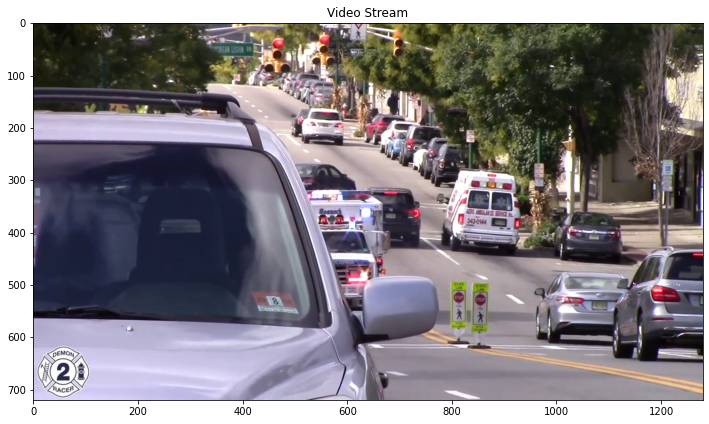

Frame number. =  105
Buffered data was truncated after reaching the output size limit.

In [ ]:
%pylab inline 
import cv2
from IPython.display import clear_output
import pafy

url = 'https://youtu.be/xUmU_mVH_34'
urlPafy = pafy.new(url)
videoplay = urlPafy.getbest(preftype="mp4")


vid = cv2.VideoCapture(videoplay.url)

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

mot_tracker = Sort() 

fourcc = cv2.VideoWriter_fourcc(*'XVID')
cap = cv2.VideoCapture(videoplay.url)
out = None

for ii in range(1500):
    print("Frame number. = ", ii)
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x

    if out is None:
      out = cv2.VideoWriter(BASE_PATH + 'output.mp4', fourcc, 20.0, (img.shape[1],img.shape[0]), True)

    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    out.write(frame)


    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    clear_output(wait=True)
cap.release()
out.release()
cv2.destroyAllWindows()